5. Kaggle1_RoBERTa_Classification
•	RoBERTa Fine-Tuned on Data1 toddler


- Soo Kyung Bae(Scarlett), Ph.D. Student
- Dept. of Integrated Medicine(Major in Digital Healthcare)
- Yonsei University College of Medicine

In [2]:
## Import Data

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
pt=os.getcwd()
pt

'/home/skbae/Documents/skbae/ASD/paper/Pgm/Final/Submitted'

In [3]:
# import QCHAT : Kaggle data

In [7]:
# import :paper/Data
#T_ASD.to_csv('./QCHAT_T_ASD_total_Jan222024.csv', header=True, index=False)
QT_ASD = pd.read_csv('./output/QCHAT_T_ASD_total_Jan222024.csv')

In [8]:
QT_ASD.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits ',
       'A1_C2977673', 'A2_C0870532', 'A3_C4036288', 'A4_C0424091',
       'A5_C2371970', 'A6_C2370875', 'A7_C4064035', 'A8_C1854882',
       'A9_C0566243', 'A10_C4064319', 'combined'],
      dtype='object')

In [9]:
QT_ASD['Class/ASD Traits '].value_counts()

Yes    728
No     326
Name: Class/ASD Traits , dtype: int64

In [10]:
df_q=QT_ASD[['Class/ASD Traits ','combined']]

In [11]:
df_q.head()

,Class/ASD Traits,combined
0,No,", , , , , ,social interaction impairment in s..."
1,Yes,"attention and concentration deficit ,contacts ..."
2,Yes,"attention and concentration deficit , , , , , ..."
3,Yes,"attention and concentration deficit ,contacts ..."
4,Yes,"attention and concentration deficit ,contacts ..."


In [13]:
df_q.columns =['Class','text']

In [14]:
Q_ASD_mapping = {
    'No': 0, # TD
    'Yes': 1, # ASD
}

df_q['label'] = df_q['Class'].replace(Q_ASD_mapping)
df_q.label.value_counts()

/tmp/ipykernel_1652832/2840381628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q['label'] = df_q['Class'].replace(Q_ASD_mapping)


1    728
0    326
Name: label, dtype: int64

In [11]:
# PART1. Roberta : QCHAT 

In [15]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import Trainer
from transformers import DebertaTokenizer, AlbertTokenizer, BertTokenizer, RobertaTokenizer
from transformers import DebertaForSequenceClassification, AlbertForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification
from transformers import TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score


/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-02-28 13:04:44.529386: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 13:04:44.560417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 13:04:45.069790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: User

/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [16]:
import torch

if torch.cuda.is_available(): 
    print("GPU is available")

In [17]:
#set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [18]:
new_df=df_q
new_df.columns

Index(['Class', 'text', 'label'], dtype='object')

In [19]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')


In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Assuming 'd138' is your target variable
train_df = new_df
X = train_df.drop('label', axis=1)
y =  train_df['label']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Combine X_train and y_train, and reset the index
train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

# # Create Dataset and DataLoader for training set
# Dset = NextVisit(token2idx=BertVocab, label2idx=labelVocab, age2idx=ageVocab, dataframe=train_data, max_len=global_params['max_len_seq'], code='disease_sequenceF', age='age2_sequenceF', label='d138')
# trainload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'], shuffle=False, num_workers=3)

# Combine X_test and y_test, and reset the index
test_data_unseen = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [21]:
print(len(train_data))
print(len(test_data_unseen))

737
317


In [22]:
test_data_unseen.head()

,Class,text,label
0,Yes,"attention and concentration deficit ,contacts ...",1
1,Yes,"attention and concentration deficit ,contacts ...",1
2,No,"attention and concentration deficit , , , , , ...",0
3,Yes,",contacts eye , , ,does pretend play ,shiftin...",1
4,No,",contacts eye ,spontaneously pointing , ,does...",0


In [24]:
test_data_unseen.label.value_counts()

1    219
0     98
Name: label, dtype: int64

In [23]:
#Train and valid from train_data
new_df=train_data

In [ ]:
# 1. MODEL build

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from transformers import RobertaTokenizerFast
# # tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# # Initialize the tokenizer
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the dataset (with attention mask)
# encodings = tokenizer(df['clean_text'].tolist(), truncation=True, padding=True, max_length=512)
# # Set a seed for reproducibility
SEED = 42

encodings = tokenizer(new_df['text'].tolist(), truncation=True, padding=True, max_length=512)
labels = new_df['label'].tolist()

# Extract 'input_ids' and 'attention_mask' from the encodings
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']


# Split the 'input_ids', 'attention_mask', and labels into training and testing sets
train_input_ids, test_input_ids, train_attention_masks, test_attention_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2
)




In [26]:
print(f"0 : {train_labels.count(0)} / 1 : {train_labels.count(1)} / 2 : {train_labels.count(2)} / 3 : {train_labels.count(3)}")
print(f"0 : {test_labels.count(0)} / 1 : {test_labels.count(1)} / 2 : {test_labels.count(2)} / 3 : {test_labels.count(3)}")


0 : 180 / 1 : 409 / 2 : 0 / 3 : 0
0 : 48 / 1 : 100 / 2 : 0 / 3 : 0


In [27]:
import torch

class QCHATDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Create training and validation datasets
train_dataset = QCHATDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = QCHATDataset(test_input_ids, test_attention_masks, test_labels)


# Text semantics and attention mask generation
inputs_unseen = tokenizer(test_data_unseen['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
input_ids_unseen = inputs_unseen['input_ids']
attention_masks_unseen = inputs_unseen['attention_mask']

# test dataset
test_data_unseen = QCHATDataset(input_ids_unseen, attention_masks_unseen, test_data_unseen['label'].tolist())

In [26]:
train_dataset

In [ ]:
# Train and validation data for model build

In [28]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir='./output', #         # output directory for model checkpoints
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size = 16,  # batch size for training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps
    weight_decay=1e-8,               # strength of weight decay
    logging_dir='./Roberta/log',            # directory for storing logs
    logging_steps=10,              # log saving step. 100
    evaluation_strategy="epoch",     # evaluate each `logging_steps`,
    learning_rate=2e-5,              # learning rate

)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_metrics_multiclass(p, num_classes=2):  # num_classes는 예시 값입니다. 실제 클래스 수로 변경하세요.
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Multiclass
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    # Treat each class as a binary classification
    labels_binarized = label_binarize(labels, classes=range(num_classes))
    predictions_binarized = label_binarize(predictions, classes=range(num_classes))

    # Multiclass AUROC , Average Precision
    auroc = roc_auc_score(labels_binarized, predictions_binarized, multi_class='ovr')
    avgprc = average_precision_score(labels_binarized, predictions_binarized)

    return {
        "acc": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall, 
        "auroc": auroc, 
        "avgprc": avgprc
    }


In [30]:
def compute_metrics_wrapper(p):
    return compute_metrics_multiclass(p, num_classes=2) #0,1

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_wrapper  # We will define compute_metrics function later
)
trainer.train() #


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/185 [00:00<?, ?it/s]

{'loss': 0.5875, 'learning_rate': 1.891891891891892e-05, 'epoch': 0.27}
{'loss': 0.3252, 'learning_rate': 1.783783783783784e-05, 'epoch': 0.54}
{'loss': 0.1772, 'learning_rate': 1.6756756756756757e-05, 'epoch': 0.81}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.242802232503891, 'eval_acc': 0.9391891891891891, 'eval_f1': 0.9335826477187734, 'eval_precision': 0.9210526315789473, 'eval_recall': 0.9550000000000001, 'eval_auroc': 0.9550000000000001, 'eval_avgprc': 0.9708108108108108, 'eval_runtime': 4.0765, 'eval_samples_per_second': 36.305, 'eval_steps_per_second': 4.661, 'epoch': 1.0}
{'loss': 0.2249, 'learning_rate': 1.5675675675675676e-05, 'epoch': 1.08}
{'loss': 0.1453, 'learning_rate': 1.4594594594594596e-05, 'epoch': 1.35}
{'loss': 0.1233, 'learning_rate': 1.3513513513513515e-05, 'epoch': 1.62}
{'loss': 0.0088, 'learning_rate': 1.2432432432432433e-05, 'epoch': 1.89}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0012038855347782373, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 4.3139, 'eval_samples_per_second': 34.308, 'eval_steps_per_second': 4.404, 'epoch': 2.0}
{'loss': 0.0207, 'learning_rate': 1.1351351351351352e-05, 'epoch': 2.16}
{'loss': 0.0183, 'learning_rate': 1.027027027027027e-05, 'epoch': 2.43}
{'loss': 0.0229, 'learning_rate': 9.189189189189191e-06, 'epoch': 2.7}
{'loss': 0.0562, 'learning_rate': 8.108108108108109e-06, 'epoch': 2.97}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0005707895033992827, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 4.4057, 'eval_samples_per_second': 33.593, 'eval_steps_per_second': 4.313, 'epoch': 3.0}
{'loss': 0.0009, 'learning_rate': 7.027027027027028e-06, 'epoch': 3.24}
{'loss': 0.0178, 'learning_rate': 5.945945945945947e-06, 'epoch': 3.51}
{'loss': 0.0761, 'learning_rate': 4.864864864864866e-06, 'epoch': 3.78}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0004112337774131447, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 4.4641, 'eval_samples_per_second': 33.153, 'eval_steps_per_second': 4.256, 'epoch': 4.0}
{'loss': 0.0007, 'learning_rate': 3.7837837837837844e-06, 'epoch': 4.05}
{'loss': 0.0038, 'learning_rate': 2.702702702702703e-06, 'epoch': 4.32}
{'loss': 0.0031, 'learning_rate': 1.6216216216216219e-06, 'epoch': 4.59}
{'loss': 0.0006, 'learning_rate': 5.405405405405406e-07, 'epoch': 4.86}


  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0002953617076855153, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 4.5227, 'eval_samples_per_second': 32.724, 'eval_steps_per_second': 4.201, 'epoch': 5.0}
{'train_runtime': 340.4446, 'train_samples_per_second': 8.65, 'train_steps_per_second': 0.543, 'train_loss': 0.09805386991214914, 'epoch': 5.0}


TrainOutput(global_step=185, training_loss=0.09805386991214914, metrics={'train_runtime': 340.4446, 'train_samples_per_second': 8.65, 'train_steps_per_second': 0.543, 'train_loss': 0.09805386991214914, 'epoch': 5.0})

In [44]:
trainer.save_model("./Roberta/ROBERTA_qchatmodel_Feb2024_2")

In [31]:
trainer.state.log_history

[{'loss': 0.5875,
  'learning_rate': 1.891891891891892e-05,
  'epoch': 0.27,
  'step': 10},
 {'loss': 0.3252,
  'learning_rate': 1.783783783783784e-05,
  'epoch': 0.54,
  'step': 20},
 {'loss': 0.1772,
  'learning_rate': 1.6756756756756757e-05,
  'epoch': 0.81,
  'step': 30},
 {'eval_loss': 0.242802232503891,
  'eval_acc': 0.9391891891891891,
  'eval_f1': 0.9335826477187734,
  'eval_precision': 0.9210526315789473,
  'eval_recall': 0.9550000000000001,
  'eval_auroc': 0.9550000000000001,
  'eval_avgprc': 0.9708108108108108,
  'eval_runtime': 4.0765,
  'eval_samples_per_second': 36.305,
  'eval_steps_per_second': 4.661,
  'epoch': 1.0,
  'step': 37},
 {'loss': 0.2249,
  'learning_rate': 1.5675675675675676e-05,
  'epoch': 1.08,
  'step': 40},
 {'loss': 0.1453,
  'learning_rate': 1.4594594594594596e-05,
  'epoch': 1.35,
  'step': 50},
 {'loss': 0.1233,
  'learning_rate': 1.3513513513513515e-05,
  'epoch': 1.62,
  'step': 60},
 {'loss': 0.0088,
  'learning_rate': 1.2432432432432433e-05,
  'e

/tmp/ipykernel_1652832/751717743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/tmp/ipykernel_1652832/751717743.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


  0%|          | 0/40 [00:00<?, ?it/s]

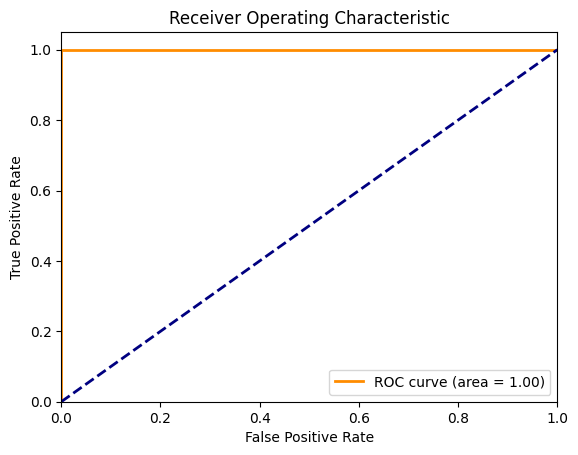

In [32]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import Trainer

# load model
# model = AutoModelForSequenceClassification.from_pretrained("./Roberta/ROBERTA_qchatmodel_Feb2024")

# Generate predictions for the evaluation dataset:test_data_unseen
predictions_output = trainer.predict(test_data_unseen)

# prediciton and lable
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# ROC curve , ROC area calculation
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# ROC curve 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
# Evaluation 
trainer.evaluate()

  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0002953617076855153,
 'eval_acc': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_auroc': 1.0,
 'eval_avgprc': 1.0,
 'eval_runtime': 42.6886,
 'eval_samples_per_second': 3.467,
 'eval_steps_per_second': 0.445,
 'epoch': 5.0}

In [38]:
# log result
log_result = trainer.state.log_history
print(log_result)

[{'loss': 0.5875, 'learning_rate': 1.891891891891892e-05, 'epoch': 0.27, 'step': 10}, {'loss': 0.3252, 'learning_rate': 1.783783783783784e-05, 'epoch': 0.54, 'step': 20}, {'loss': 0.1772, 'learning_rate': 1.6756756756756757e-05, 'epoch': 0.81, 'step': 30}, {'eval_loss': 0.242802232503891, 'eval_acc': 0.9391891891891891, 'eval_f1': 0.9335826477187734, 'eval_precision': 0.9210526315789473, 'eval_recall': 0.9550000000000001, 'eval_auroc': 0.9550000000000001, 'eval_avgprc': 0.9708108108108108, 'eval_runtime': 4.0765, 'eval_samples_per_second': 36.305, 'eval_steps_per_second': 4.661, 'epoch': 1.0, 'step': 37}, {'loss': 0.2249, 'learning_rate': 1.5675675675675676e-05, 'epoch': 1.08, 'step': 40}, {'loss': 0.1453, 'learning_rate': 1.4594594594594596e-05, 'epoch': 1.35, 'step': 50}, {'loss': 0.1233, 'learning_rate': 1.3513513513513515e-05, 'epoch': 1.62, 'step': 60}, {'loss': 0.0088, 'learning_rate': 1.2432432432432433e-05, 'epoch': 1.89, 'step': 70}, {'eval_loss': 0.0012038855347782373, 'eval_

In [35]:
# Evaluate the model
results = trainer.evaluate(test_data_unseen)

print(results)

/tmp/ipykernel_1652832/751717743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/tmp/ipykernel_1652832/751717743.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 0.0013068669941276312, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 80.2118, 'eval_samples_per_second': 3.952, 'eval_steps_per_second': 0.499, 'epoch': 5.0}


In [43]:
# Evaluate the model
results = trainer.evaluate(test_dataset)
print(results)

  0%|          | 0/19 [00:00<?, ?it/s]

{'eval_loss': 0.0002953617076855153, 'eval_acc': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_auroc': 1.0, 'eval_avgprc': 1.0, 'eval_runtime': 45.0199, 'eval_samples_per_second': 3.287, 'eval_steps_per_second': 0.422, 'epoch': 5.0}


In [ ]:
# 2. need to aply to the unseen data 

{'loss': 0.5875, 'learning_rate': 1.891891891891892e-05, 'epoch': 0.27, 'step': 10}
{'loss': 0.3252, 'learning_rate': 1.783783783783784e-05, 'epoch': 0.54, 'step': 20}
{'loss': 0.1772, 'learning_rate': 1.6756756756756757e-05, 'epoch': 0.81, 'step': 30}
{'eval_loss': 0.242802232503891, 'eval_acc': 0.9391891891891891, 'eval_f1': 0.9335826477187734, 'eval_precision': 0.9210526315789473, 'eval_recall': 0.9550000000000001, 'eval_auroc': 0.9550000000000001, 'eval_avgprc': 0.9708108108108108, 'eval_runtime': 4.0765, 'eval_samples_per_second': 36.305, 'eval_steps_per_second': 4.661, 'epoch': 1.0, 'step': 37}
{'loss': 0.2249, 'learning_rate': 1.5675675675675676e-05, 'epoch': 1.08, 'step': 40}
{'loss': 0.1453, 'learning_rate': 1.4594594594594596e-05, 'epoch': 1.35, 'step': 50}
{'loss': 0.1233, 'learning_rate': 1.3513513513513515e-05, 'epoch': 1.62, 'step': 60}
{'loss': 0.0088, 'learning_rate': 1.2432432432432433e-05, 'epoch': 1.89, 'step': 70}
{'eval_loss': 0.0012038855347782373, 'eval_acc': 1.0

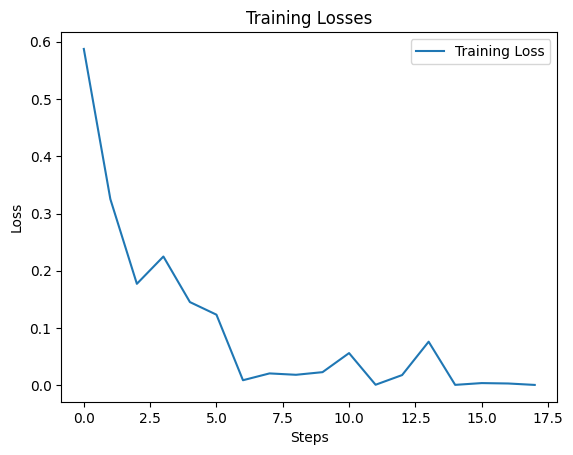

In [39]:
train_losses = []
eval_losses = []
for elem in trainer.state.log_history:
      print(elem)
      if 'loss' in elem.keys():
        train_losses.append(elem['loss'])

# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [37]:
# # Generate predictions
# predictions_output = trainer.predict(test_dataset)

# # Extract the predictions and true labels
# predictions = np.argmax(predictions_output.predictions, axis=-1)
# true_labels = predictions_output.label_ids

  0%|          | 0/19 [00:00<?, ?it/s]

In [40]:
# Generate predictions
predictions_output = trainer.predict(test_data_unseen)

# Extract the predictions and true labels
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

/tmp/ipykernel_1652832/751717743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/tmp/ipykernel_1652832/751717743.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


  0%|          | 0/40 [00:00<?, ?it/s]

In [41]:
df_results = pd.DataFrame({'True_Labels': true_labels, 'Predictions': predictions})

# Display the DataFrame
print(df_results.head())

   True_Labels  Predictions
0            1            1
1            1            1
2            0            0
3            1            1
4            0            0


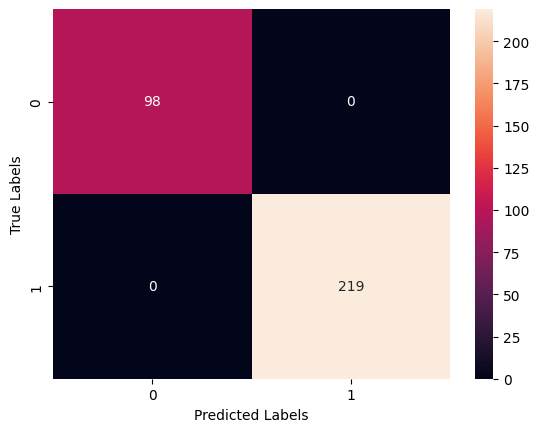

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()